# Preminary operations

Let us start by importing the relevant packages

In [90]:
import gcp.bigquery as bq
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

## Let us explore the dataset

In [2]:
%%sql 
SELECT * FROM [google.com:ddm-connectors-demo:aw_dataset.__TABLES__];

project_id,dataset_id,table_id,creation_time,last_modified_time,row_count,size_bytes,type
google.com:ddm-connectors-demo,aw_dataset,ACCOUNT_PERFORMANCE_DEVICE,1462865492924,1462865646222,344872,213766803,1
google.com:ddm-connectors-demo,aw_dataset,ACCOUNT_PERFORMANCE_HOUR_OF_DAY,1462866241157,1462868328687,7585976,4293195830,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_DEVICE,1462882853869,1462884926720,12818403,11156943261,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_GA,1462886351515,1462888587490,12818403,11092304675,1
google.com:ddm-connectors-demo,aw_dataset,CAMPAIGN_PERFORMANCE_HOUR_OF_DAY,1462890199029,1462910444516,149020493,120843835228,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_PERFORMANCE_ANALYTICS,1462965362235,1463059120058,295426051,435427263267,1
google.com:ddm-connectors-demo,aw_dataset,KEYWORDS_PERFORMANCE_DEVICE,1463050362280,1463408383328,447387461,631380449113,1


## Lest us explore the table KEYWORDS_PERFORMANCE_ANALYTICS

In [3]:
%bigquery schema --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS

## Let us see how the data look like

In [4]:
%bigquery sample --table google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS --count 5

AccountCurrencyCode,AccountDescriptiveName,AccountTimeZoneId,ActiveViewCpm,ActiveViewCtr,ActiveViewImpressions,ActiveViewMeasurability,ActiveViewMeasurableCost,ActiveViewMeasurableImpressions,ActiveViewViewability,AdGroupId,AdGroupName,AdGroupStatus,AdNetworkType1,AdNetworkType2,AllConversionRate,AllConversions,AllConversionValue,ApprovalStatus,AverageCost,AverageCpc,AverageCpe,AverageCpm,AverageCpv,AveragePageviews,AveragePosition,AverageTimeOnSite,BaseAdGroupId,BaseCampaignId,BiddingStrategyId,BiddingStrategyName,BiddingStrategySource,BiddingStrategyType,BidType,BounceRate,CampaignId,CampaignName,CampaignStatus,ClickAssistedConversionsOverLastClickConversions,ClickAssistedConversionValue,ClickConversionRate,Clicks,ConversionRate,Conversions,ConversionValue,ConvertedClicks,Cost,CostPerAllConversion,CostPerConversion,CostPerConvertedClick,CpcBid,CpcBidSource,CpmBid,CreativeQualityScore,Criteria,CriteriaDestinationUrl,CrossDeviceConversions,Ctr,CustomerDescriptiveName,Date,DayOfWeek,EngagementRate,Engagements,EnhancedCpcEnabled,EstimatedAddClicksAtFirstPositionCpc,EstimatedAddCostAtFirstPositionCpc,ExternalCustomerId,FinalAppUrls,FinalMobileUrls,FinalUrls,FirstPageCpc,FirstPositionCpc,GmailForwards,GmailSaves,GmailSecondaryClicks,Id,ImpressionAssistedConversions,ImpressionAssistedConversionsOverLastClickConversions,ImpressionAssistedConversionValue,Impressions,InteractionRate,Interactions,IsNegative,KeywordMatchType,LabelIds,Labels,Month,MonthOfYear,PercentNewVisitors,PostClickQualityScore,PrimaryCompanyName,QualityScore,Quarter,SearchExactMatchImpressionShare,SearchImpressionShare,SearchPredictedCtr,SearchRankLostImpressionShare,Status,SystemServingStatus,TopOfPageCpc,TrackingUrlTemplate,UrlCustomParameters,ValuePerAllConversion,ValuePerConversion,ValuePerConvertedClick,VideoQuartile100Rate,VideoQuartile25Rate,VideoQuartile50Rate,VideoQuartile75Rate,VideoViewRate,VideoViews,ViewThroughConversions,Week,Year
EUR,Bravofly FR,(GMT+01:00) Paris,20000000,11.11%,9,100.00%,180000,11,81.82%,4742873125,Bravofly Misspellings,enabled,Display Network,Display Network,0.00%,0.0,0.0,--,180000,180000,0,16363636,0,1.0,1.0,0,4742873125,98913565,0,--,campaign,cpc,--,100.00%,98913565,Brand Content,enabled,0.0,0.0,0.00%,1,0.00%,0.0,0.0,0,180000,0,0,0,--,--,--,Not applicable,Content,--,0.0,9.09%,Bravofly FR,2015-09-30,Wednesday,0.00%,0,False,--,--,9348411392,--,--,--,0,0,0,0,0,3000000,0,0.0,0.0,11,9.09%,1,False,Broad,--,--,2015-09-01,September,100.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-07-01,--,--,Not applicable,--,enabled,eligible,0,--,--,0.0,0.0,0.0,0.00%,0.00%,0.00%,0.00%,0.00%,0,0,2015-09-28,2015
EUR,Bravofly Russia Voli,(GMT+01:00) Rome,0,0.00%,0,0.00%,0,0,0.00%,3639849698,Bravoavia,enabled,Search Network,Google search,0.00%,0.0,0.0,--,140000,140000,0,17500000,0,7.0,4.8,139,3639849698,108030218,0,--,campaign,cpc,--,0.00%,108030218,Brand_RU_Broad,enabled,0.0,0.0,0.00%,1,0.00%,0.0,0.0,0,140000,0,0,0,--,--,--,Not applicable,бравоавиа билеты,--,0.0,12.50%,Bravofly Russia Voli,2015-03-22,Sunday,0.00%,0,False,--,--,9837210897,--,--,--,0,0,0,0,0,33239627618,0,0.0,0.0,8,12.50%,1,False,Broad,--,--,2015-03-01,March,0.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-01-01,--,57.14%,Not applicable,42.86%,removed,--,0,--,--,0.0,0.0,0.0,0.00%,0.00%,0.00%,0.00%,0.00%,0,0,2015-03-16,2015
EUR,Bravofly Russia Voli,(GMT+01:00) Rome,0,0.00%,0,0.00%,0,0,0.00%,3639850178,Bravofly,enabled,Search Network,Search partners,0.00%,0.0,0.0,--,0,0,0,0,0,0.0,1.0,0,3639850178,108030218,0,--,campaign,cpc,--,0.00%,108030218,Brand_RU_Broad,enabled,0.0,0.0,0.00%,0,0.00%,0.0,0.0,0,0,0,0,0,--,--,--,Not applicable,bravofly,--,0.0,0.00%,Bravofly Russia Voli,2015-03-19,Thursday,0.00%,0,False,--,--,9837210897,--,--,--,0,0,0,0,0,3117710189,0,0.0,0.0,1,0.00%,0,False,Phrase,--,--,2015-03-01,March,0.00%,Not applicable,"Red Universal de Marketing y Bookings On Line, S.A.",0,2015-01-01,--,100.00%,Not applicable,0.00%,remo

# Let us start checking the monthly performance on Volagratis in Italy

In [44]:
%sql --module monthly_keywords_performance
SELECT
  AccountDescriptiveName,
  CampaignName,
  AdGroupName,
  Criteria,
  KeywordMatchType,
  COUNT(Month) as MonthsWithImpressions,
  AVG(Impressions) as Impressions,
  AVG(ImpressionAssistedConversions) as ImpressionAssistedConversions,
  AVG(Clicks) as Clicks,
  AVG(ClickAssistedConversions) as ClickAssistedConversions,  
  AVG(CTR) as CTR,
  AVG(QualityScore) as QualityScore, 
  AVG(CostEUR) as CostEUR,
  AVG(AllConversions) as AllConversions,
  AVG(Conversions) as Conversions,    
  AVG(CostPerAllConversion) as CostPerAllConversion,
  AVG(CostPerConversion) as CostPerConversion,  
  #Analytics Metrics
  AVG(BounceRate) as BounceRate,
  AVG(AveragePosition) as AveragePosition,
  AVG(AveragePageviews) as AveragePageviews,
  AVG(AverageTimeOnSite) as AverageTimeOnSite,
  AVG(PercentNewVisitors) as PercentNewVisitors,
FROM
(
SELECT
  Month,
  AccountDescriptiveName,
  CampaignName,
  AdGroupName,
  Criteria,
  KeywordMatchType,
  SUM(Impressions) as Impressions,
  SUM(ImpressionAssistedConversions) as ImpressionAssistedConversions,
  SUM(Clicks) as Clicks,
  SUM(Clicks)/SUM(Impressions) as CTR,
  SUM(IF(ClickAssistedConversionsOverLastClickConversions = 0, 0,
  CASE
    WHEN Conversions > 0 OR AllConversions > 0 THEN IF(AllConversions>Conversions,AllConversions,Conversions)*ClickAssistedConversionsOverLastClickConversions
    WHEN ImpressionAssistedConversions > 0 THEN ImpressionAssistedConversions*ClickAssistedConversionsOverLastClickConversions
    ELSE 1.0
  END
  )) as ClickAssistedConversions,
  
  AVG(QualityScore) as QualityScore,
  
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000 as CostEUR,
  SUM(AllConversions) as AllConversions,
  SUM(Conversions) as Conversions,  
  
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000/SUM(AllConversions) as CostPerAllConversion,
  SUM(IF(AccountCurrencyCode = 'GBP', Cost*1.37, Cost*1.0))/1000000/SUM(Conversions) as CostPerConversion,
  
  #Analytics Metrics
  SUM(FLOAT(RTRIM(BounceRate,'%'))/100.0 * Clicks)/SUM(Clicks) as BounceRate,
  SUM(AveragePosition * Impressions)/SUM(Impressions) as AveragePosition,
  SUM(AveragePageviews * Clicks)/SUM(Clicks) as AveragePageviews,
  SUM(AverageTimeOnSite * Clicks)/SUM(Clicks) as AverageTimeOnSite,
  SUM(FLOAT(RTRIM(PercentNewVisitors,'%'))/100.0 * Clicks)/SUM(Clicks) as PercentNewVisitors,

FROM
  [google.com:ddm-connectors-demo:aw_dataset.KEYWORDS_PERFORMANCE_ANALYTICS]
WHERE TRUE
AND NOT IsNegative
AND AdNetworkType2 = 'Google search'
AND Impressions > 0 
AND Year = 2016
AND AccountDescriptiveName IN ('Account Primario Volagratis','Volagratis Tratte Italia','Volagratis')
GROUP BY 1,2,3,4,5,6)
GROUP BY 1,2,3,4,5

In [45]:
df = bq.Query(monthly_keywords_performance).to_dataframe()

First of all let us identify the Brand Keywords assuming that 
- they have at least 10 impressions a month
- their CTR is higher the "normal"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d486dbd90>]], dtype=object)

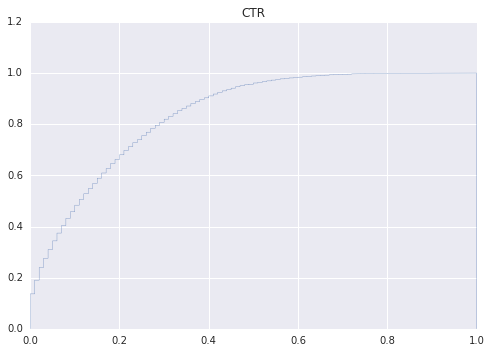

In [54]:
df[df['Impressions']>10].hist('CTR',bins=np.arange(101)/100.0,
                              normed=True,cumulative=1,histtype='step')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d47e15410>]], dtype=object)

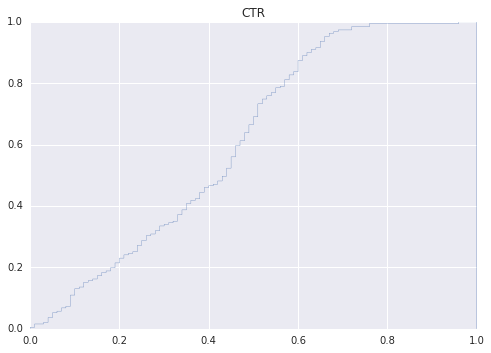

In [69]:
df[(df['AdGroupName'] == 'Brand')&(df['Impressions']>10)].hist('CTR',bins=np.arange(101)/100.0,
                                                              cumulative=1,normed=1,
                                                               histtype='step')

In [70]:
df[(df['AdGroupName'] == 'Brand')&
   (df['CTR']<0.4)&
   (df['Impressions']>10)].sort_values(by='CostEUR',ascending=False)[['AccountDescriptiveName',
                                                                                        'CampaignName',
                                                                                        'AdGroupName',
                                                                                        'Criteria',
                                                                                        'KeywordMatchType',
                                                                                        'CTR',
                                                                                        'Impressions',
                                                                                        'CostEUR']]

,AccountDescriptiveName,CampaignName,AdGroupName,Criteria,KeywordMatchType,CTR,Impressions,CostEUR
58488,Account Primario Volagratis,Volagratis Brand 2008,Brand,+vola +gratis,Broad,0.297325,13794.500000,1243.685000
66333,Account Primario Volagratis,Volagratis Brand 2008,Brand,volagratis,Broad,0.224826,10817.500000,660.385000
150559,Account Primario Volagratis,Volagratis Brand 2008,Brand,+volagratis,Broad,0.296902,8457.750000,590.672500
93827,Account Primario Volagratis,Volagratis Brand 2008,Brand,volaregratis,Broad,0.167032,4562.000000,260.050000
13216,Account Primario Volagratis,Volagratis Brand 2008,Brand,volarequasigratis,Broad,0.131890,5914.000000,259.500000
130584,Account Primario Volagratis,Volagratis Brand 2008,Brand,viaggiogratis,Broad,0.090241,4499.000000,255.890000
7777,Account Primario Volagratis,Volagratis Brand 2008,Brand,+volagratis. +com,Broad,0.246051,1877.750000,103.552500
105173,Account Primario Volagratis,Volagratis Brand 2008,Brand,+voli +gratis,Broad,0.244225,596.000000,48.150000
149992,Account Primario Volagratis,Volagratis Brand 2008,Brand,+volagratis +prenotazione,Broad,0.126770,733.000000,44.845000
53981,Account Primario Volagratis,Volagratis Brand 2008,Brand,volare gratis,Broad,0.093334,2942.000000,44.595000


In [68]:
df[(df['Impressions']>10) & (df['CTR']>0.4)].sort_values(by='CostEUR',ascending=False)[['AccountDescriptiveName',
                                                                                        'CampaignName',
                                                                                        'AdGroupName',
                                                                                        'Criteria',
                                                                                        'KeywordMatchType',
                                                                                        'CTR',
                                                                                        'Impressions',
                                                                                        'CostEUR']]

,AccountDescriptiveName,CampaignName,AdGroupName,Criteria,KeywordMatchType,CTR,Impressions,CostEUR
67977,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volagratis,Exact,0.512981,752063.500000,24342.210000
74235,Account Primario Volagratis,Volagratis Brand 2008 - Exact Experiment Cross...,Brand,volagratis,Exact,0.495577,96324.000000,1883.100000
114985,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,vola+gratis,Exact,0.515747,33721.500000,1326.177500
135351,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Missp,voli gratis,Exact,0.528934,7947.500000,940.237500
76548,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volare+gratis,Exact,0.529607,13439.750000,763.860000
142989,Account Primario Volagratis,Volagratis Brand 2008,Voli Brand,+volagratis +volo,Broad,0.457367,4743.250000,604.257500
80966,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volagratis offerte speciali,Exact,0.652958,2975.000000,542.875000
43425,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volagratis offerte,Exact,0.651954,5517.750000,515.712500
134608,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Missp,vologratis,Exact,0.589290,6880.500000,401.912500
79613,Account Primario Volagratis,Volagratis Brand 2008 - Exact,Brand,volaregratis,Exact,0.483906,13941.750000,318.510000


In [72]:
df['KeywordType'] = df.apply(lambda x: 'Gold' if 
                             (x['Impressions']>10 and x['CTR']>0.4) 
                             else 'Standard', axis=1)


Let us start assessing the performance of the keywords

In [73]:
df.groupby(by=(df['AllConversions'] > 0))[['AllConversions','CostEUR',
                                           'Impressions','Clicks',
                                           'Criteria']].aggregate({'AllConversions':sum,
                                                                   'CostEUR':sum,
                                                                   'Impressions':sum,
                                                                   'Clicks':sum,
                                                                   'Criteria':'count'})

,Impressions,CostEUR,Clicks,AllConversions,Criteria
AllConversions,,,,,
False,2.707570e+06,128969.6125,3.272166e+05,0.00,159796
True,6.563169e+06,357421.8450,1.202290e+06,27315.25,8023


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d47891350>]], dtype=object)

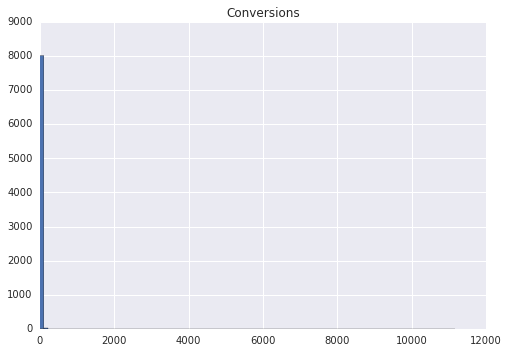

In [76]:
df[df['AllConversions'] > 0].hist('Conversions',bins=100)

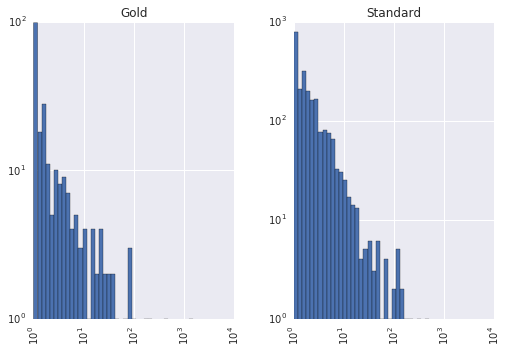

In [82]:
axes = df.hist('Conversions',bins=np.logspace(0,4),log=True,by='KeywordType')
axes[0].set_xscale('log')
axes[1].set_xscale('log')

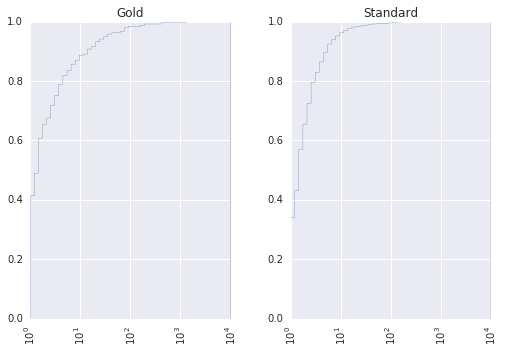

In [85]:
axes = df.hist('Conversions',bins=np.logspace(0,4),by='KeywordType',
              cumulative=1,normed=True,histtype='step')
axes[0].set_xscale('log')
axes[1].set_xscale('log')

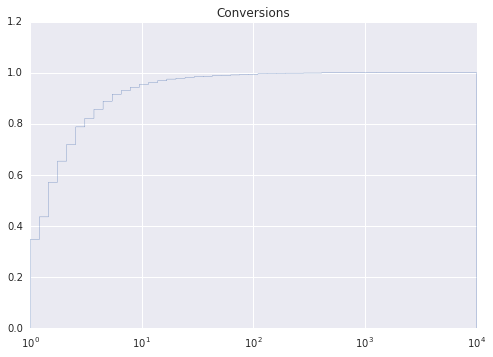

In [88]:
df.hist('Conversions',bins=np.logspace(0,4),
              cumulative=1,normed=True,histtype='step')
plt.gca().set_xscale('log')

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


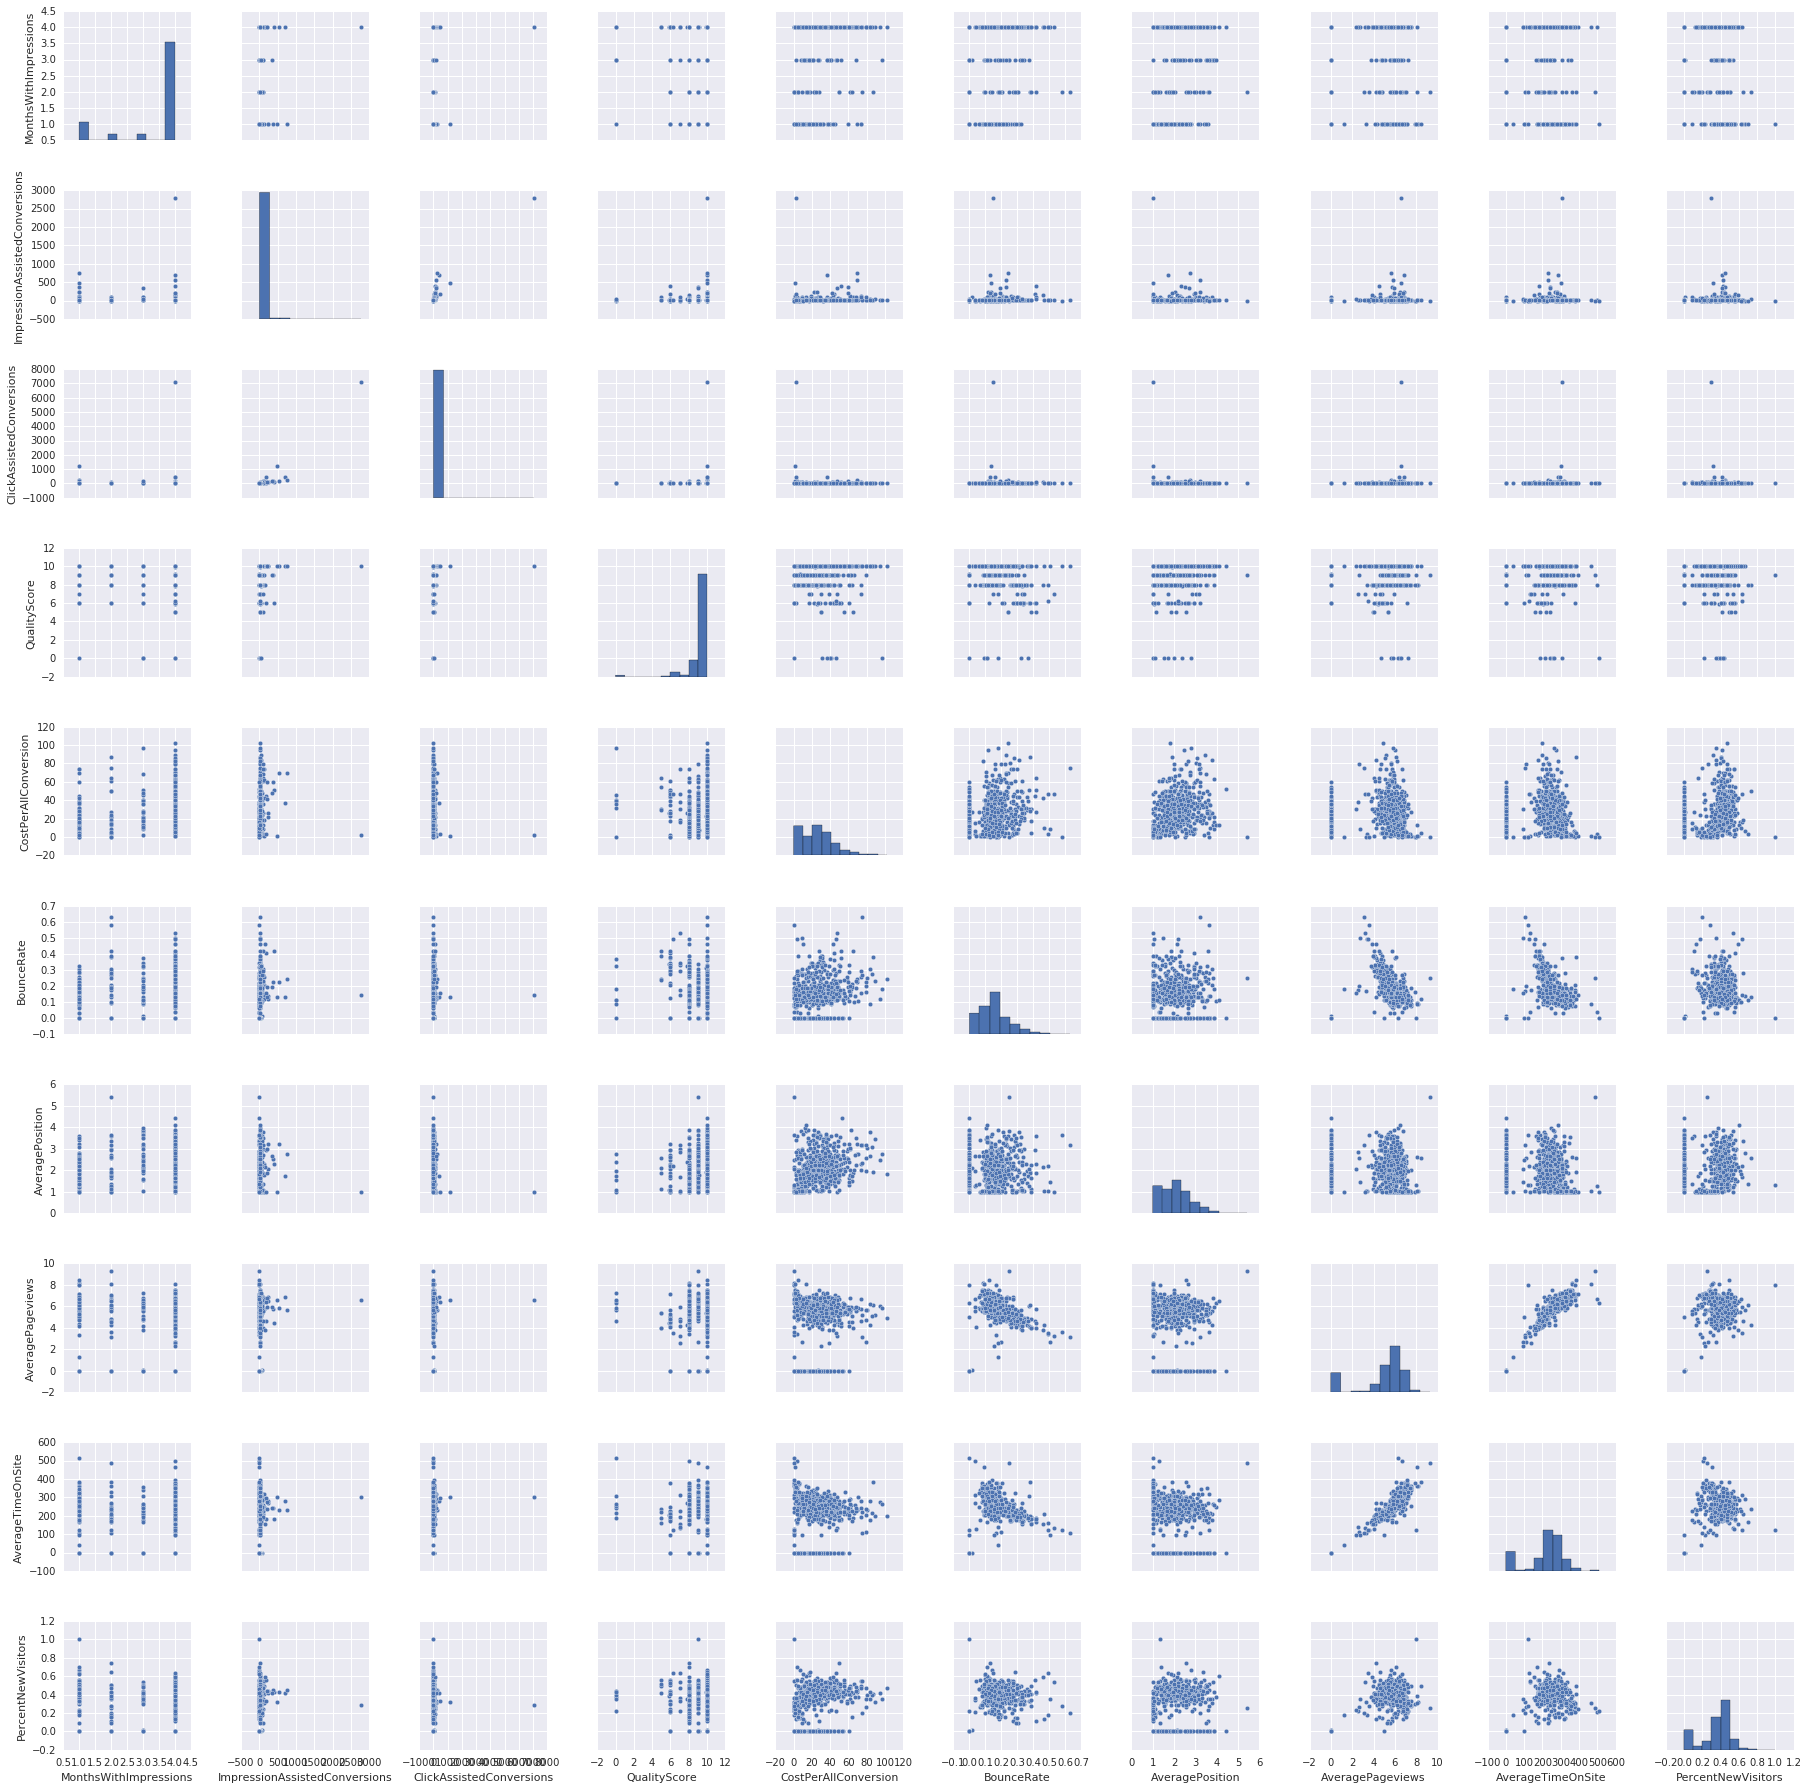

In [94]:
g = sns.pairplot(data=df[df['AllConversions']>3][[u'KeywordMatchType',u'MonthsWithImpressions',
                            u'ImpressionAssistedConversions',u'ClickAssistedConversions',
                            u'QualityScore',u'CostPerAllConversion',
                            u'KeywordType',u'BounceRate',
                            u'AveragePosition', u'AveragePageviews',
                            u'AverageTimeOnSite',u'PercentNewVisitors']])

In [89]:
df.columns

Index([       u'AccountDescriptiveName',                  u'CampaignName',
                         u'AdGroupName',                      u'Criteria',
                    u'KeywordMatchType',         u'MonthsWithImpressions',
                         u'Impressions', u'ImpressionAssistedConversions',
                              u'Clicks',      u'ClickAssistedConversions',
                                 u'CTR',                  u'QualityScore',
                             u'CostEUR',                u'AllConversions',
                         u'Conversions',          u'CostPerAllConversion',
                   u'CostPerConversion',                    u'BounceRate',
                     u'AveragePosition',              u'AveragePageviews',
                   u'AverageTimeOnSite',            u'PercentNewVisitors',
                         u'KeywordType'],
      dtype='object')